<a href="https://www.kaggle.com/code/ajayidaniel/amazon-planet-analysis?scriptVersionId=117145555" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from subprocess import check_output
import matplotlib.pyplot as plt
import seaborn as sns 
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
import cv2
import os
from tqdm import tqdm

In [2]:
!ls ../input/planets-dataset/planet/planet

sample_submission.csv  test-jpg  train-jpg  train_classes.csv


In [3]:
path = "../input/planets-dataset/planet/planet/"
train_path = os.path.join(path, "train-jpg")
test_path = os.path.join(path, "test-jpg")
class_path = os.path.join(path, "train_classes.csv")
submission_path = os.path.join(path, "sample_submission.csv")

In [4]:
train_classes = pd.read_csv(class_path)
sample_sub = pd.read_csv(submission_path)

print(train_classes.shape)
print(sample_sub.shape)

(40479, 2)
(61191, 2)


In [5]:
#checking how the labels files looks like 
train_classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
#splitting Tags and printing all unique classes 

from itertools import chain 
labels_list = list(chain.from_iterable([tags.split(" ")
for tags in train_classes['tags'].values]))

num_labels = len(labels_list)
unique_labels = set(labels_list)
num_unique = len(unique_labels)
print("There are {} labels in the training set".format(num_labels))
print("and {} unique labels".format(num_unique))    
print("which are {}".format(unique_labels)) 
      

There are 116278 labels in the training set
and 17 unique labels
which are {'slash_burn', 'conventional_mine', 'water', 'blow_down', 'haze', 'bare_ground', 'road', 'agriculture', 'clear', 'cultivation', 'blooming', 'artisinal_mine', 'partly_cloudy', 'habitation', 'selective_logging', 'cloudy', 'primary'}


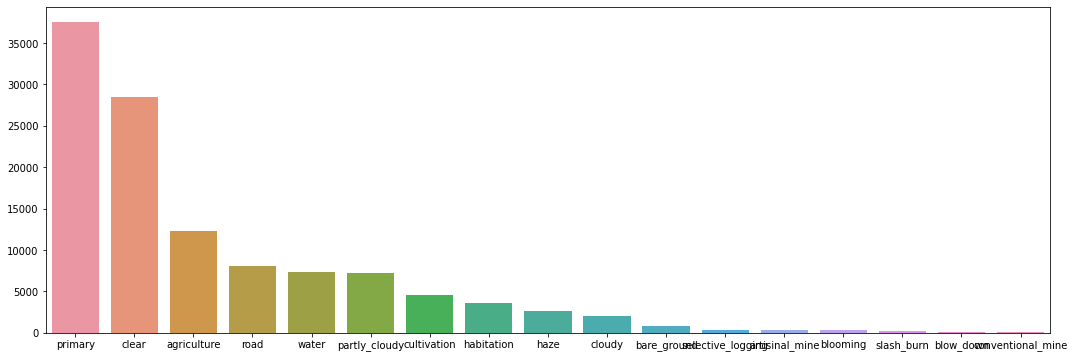

In [7]:
#Histogram of label instances
Hist_labels = pd.Series(labels_list).value_counts()

fig,ax = plt.subplots(figsize=(18,6))
sns.barplot(x=Hist_labels.index, y=Hist_labels, orient = "v")
plt.show()

In [8]:
# Free up some memory that is not being used by the program
import gc
gc.collect()

21

In [9]:
# Initialization and Image Reading

# Initialize empty lists to store the training images and their labels
x_train = []
y_train = []

# Flatten the list of tags
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in train_classes['tags'].values])))

# Create a label map for the unique tags in the dataset
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Loop through the training DataFrame
for f, tags in tqdm(train_classes.values, miniters=1000):
    # Read the image file
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    # Initialize an array of zeros for the targets
    targets = np.zeros(17)
    # Loop through the tags for the current image
    for t in tags.split(' '):
        # Set the corresponding target value to 1
        targets[label_map[t]] = 1 
    # Append the image and its labels to the appropriate lists
    x_train.append(cv2.resize(img, (64, 64)))  # Indicate the IMG Size
    y_train.append(targets)

# Convert the lists to numpy arrays
x_train = np.array(x_train, np.float16) / 255.
y_train = np.array(y_train, np.uint8)

100%|██████████| 40479/40479 [07:40<00:00, 87.99it/s]


In [10]:
import gc 
gc.collect()

21

In [11]:
#Converting the lists of images and labels to numpy arrays and normalizing the pixel values of the images. 
#y_train = np.array(y_train, np.uint8)
#x_train = np.array(x_train, np.float16)/ 255.

#Splitting the data into train and validation sets. 
x_train,x_val,y_train,y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 20)

#Prints the shape of the training and validation data.
print("Train data shape:",x_train.shape)
print("Train label shape:",y_train.shape)
print("Validation data shape:",x_val.shape)
print("Validation label shape:",y_val.shape)

Train data shape: (32383, 64, 64, 3)
Train label shape: (32383, 17)
Validation data shape: (8096, 64, 64, 3)
Validation label shape: (8096, 17)


In [12]:
# Free up some memory that is not being used by the program
import gc
gc.collect()

42

In [13]:
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [14]:
def my_model():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(64,64, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    return model
    
  

In [15]:
# Free up some memory that is not being used by the program
import gc
gc.collect()

21

In [16]:
model = my_model()
model.summary()

2023-01-24 01:40:50.595079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        3

2023-01-24 01:40:50.683299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 01:40:50.684197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 01:40:50.686231: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 01:40:50.686573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [17]:
model.compile(loss='binary_crossentropy',
            optimizer = 'adam' ,
            metrics=[fbeta_score_K,'accuracy'])
callback = EarlyStopping(
                    monitor= 'val_loss', 
                    patience=2,
                    verbose=2,
                    baseline=None,
                    restore_best_weights =True)

In [18]:
data_gen = ImageDataGenerator(rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

data_gen.fit(x_train)
data_gen.fit(x_val)

In [19]:
import gc
gc.collect()

188

In [20]:
train_steps = len(x_train)//64
val_steps = len(x_val)//64

In [21]:
history = model.fit_generator(data_gen.flow(x_train,y_train,batch_size = 64),
                    steps_per_epoch = train_steps,
                    validation_data =data_gen.flow(x_val,y_val,batch_size = 64),
                    validation_steps = val_steps,
                    epochs=15,
                    callbacks=[callback]) 

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-01-24 01:40:59.594325: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-24 01:41:01.488315: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


505/505 [==============================] - 55s 93ms/step - loss: 0.2213 - fbeta_score_K: 0.6248 - accuracy: 0.0158 - val_loss: 0.1766 - val_fbeta_score_K: 0.6764 - val_accuracy: 0.0356
Epoch 2/15
505/505 [==============================] - 47s 93ms/step - loss: 0.1751 - fbeta_score_K: 0.6999 - accuracy: 0.0362 - val_loss: 0.1675 - val_fbeta_score_K: 0.7254 - val_accuracy: 0.0126
Epoch 3/15
505/505 [==============================] - 46s 92ms/step - loss: 0.1634 - fbeta_score_K: 0.7194 - accuracy: 0.0463 - val_loss: 0.1494 - val_fbeta_score_K: 0.7355 - val_accuracy: 0.0537
Epoch 4/15
505/505 [==============================] - 47s 93ms/step - loss: 0.1554 - fbeta_score_K: 0.7338 - accuracy: 0.0498 - val_loss: 0.1470 - val_fbeta_score_K: 0.7431 - val_accuracy: 0.0470
Epoch 5/15
505/505 [==============================] - 47s 93ms/step - loss: 0.1517 - fbeta_score_K: 0.7401 - accuracy: 0.0455 - val_loss: 0.1503 - val_fbeta_score_K: 0.7289 - val_accuracy: 0.0433
Epoch 6/15
505/505 [===========

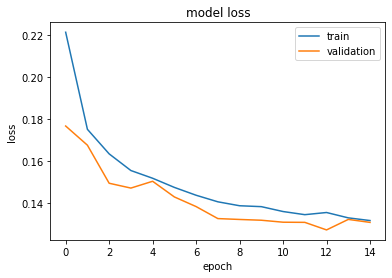

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Adding title, y-label and x-label to the plot
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper right')

# Showing the plot
plt.show()

In [23]:
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100 - score * 100))

F beta score:  0.8948119912552646
Error: 10.52%


In [24]:
import gc
gc.collect()

4166

In [25]:
#The DataFrame 'samplesubs' now contains the data from the sample submission CSV file
# Create two separate DataFrames for the test and additional test files

# The first DataFrame will contain the labels for the test-jpg files
test = sample_sub[0 : 40669]

# The second DataFrame will contain the labels for the test-jpg-additional files
files = sample_sub[40669 : ]

In [26]:
# Initialize an empty list to store the images
test_img = []

# Loop through the test DataFrame
for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    test_img.append(cv2.resize(arr, (64, 64)))

# Loop through the additional test files DataFrame
for image_name, tags in tqdm(files.values, miniters=1000):
    # Read the image file
    arr = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    test_img.append(cv2.resize(arr, (64, 64)))

    
test_img = np.array(test_img, np.float16)/255.0
test_steps = len(test_img)//64

100%|██████████| 20522/20522 [03:59<00:00, 85.77it/s]


In [27]:
import gc 
gc.collect()

21

In [28]:
# Running the predictions

# Initialize an empty list to store the predictions
y_predictions = []

# Make predictions on the test images using the model
predictions = model.predict(test_img, batch_size = 64, verbose=2 )

# Append the predictions to the yres list
y_predictions.append(predictions)


2023-01-24 02:11:37.722456: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3007660032 exceeds 10% of free system memory.
2023-01-24 02:11:42.302106: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3007660032 exceeds 10% of free system memory.


957/957 - 3s


In [29]:
gc.collect()

788

In [30]:
# form

# Initialize an empty array to store the decoded labels
sub = np.array(y_predictions[0])

# Loop through the encoded labels
for i in range (1, len(y_predictions)):
    # Add the encoded label to the array
    sub += np.array(yres[i])

# Convert the array to a DataFrame
sub = pd.DataFrame(sub, columns = label_map)

In [31]:
#Create the submission file format

# Initialize an empty list to store the predictions
preds = []

# Loop through the sample submission DataFrame
for i in tqdm(range(sub.shape[0]), miniters=1000):
    # Get the i-th row of the DataFrame
    a = sub.loc[[i]]
    # Apply a lambda function to get a Boolean array indicating which columns have values greater than 0.2
    a = a.apply(lambda x: x > 0.2, axis=1)
    # Transpose the DataFrame
    a = a.transpose()
    # Get the rows where the Boolean array is True
    a= a.loc[a[i] == True]
    # Join the index of the DataFrame (which contains the tags) into a single string
    ' '.join(list(a.index))
    # Append the string of tags to the preds list
    preds.append(' '.join(list(a.index)))
    
#Assign the preds list as the 'tags' column of the sample submission DataFrame
sample_sub['tags'] = preds
#Save the sample submission DataFrame to a CSV file
sample_sub.to_csv('samp_submission.csv', index=False)

100%|██████████| 61191/61191 [01:50<00:00, 554.72it/s]
